In [7]:
import numpy as np
import pandas as pd

In [8]:
from keras.layers import Input, Dense
from keras.models import Model

In [9]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

## Delta M - Delta t 

Now with the deltamdeltat diagrams

In [10]:
df_mira = pd.read_csv('ATLAS_LC/MIRA_features_table.csv')
signature_cols = [col for col in df_mira.columns if 'Deltam' in col]
#plt.imshow(df_mira[signature_cols].iloc[2787].as_matrix().reshape(23, 24).T, cmap='inferno')
#plt.show()

In [11]:
signature_cols += ['OBJID', 'filter', 'CLASS']
df_mira = df_mira[signature_cols]

In [12]:
df_mpulse = pd.read_csv('ATLAS_LC/MPULSE_features_table.csv')[signature_cols]
df_dbf = pd.read_csv('ATLAS_LC/DBF_features_table.csv')[signature_cols]
df_lpv = pd.read_csv('ATLAS_LC/LPV_features_table.csv')[signature_cols]
df_dbh = pd.read_csv('ATLAS_LC/DBH_features_table.csv')[signature_cols]
df_pulse = pd.read_csv('ATLAS_LC/PULSE_features_table.csv')[signature_cols]
df_nsine = pd.read_csv('ATLAS_LC/NSINE_features_table.csv')[signature_cols]
df_sine = pd.read_csv('ATLAS_LC/SINE_features_table.csv')[signature_cols]
df_msine = pd.read_csv('ATLAS_LC/MSINE_features_table.csv')[signature_cols]
df_cbh = pd.read_csv('ATLAS_LC/CBH_features_table.csv')[signature_cols]
df_cbf = pd.read_csv('ATLAS_LC/CBF_features_table.csv')[signature_cols]
df_irr = pd.read_csv('ATLAS_LC/IRR_features_table.csv')[signature_cols]

In [13]:
full_data = pd.concat([df_mira, df_mpulse, df_dbf, df_lpv, df_dbh, df_pulse, 
                       df_nsine, df_sine, df_msine, df_cbf, df_cbh])
signature_cols = [col for col in df_mira.columns if 'Deltam' in col]
X = full_data[signature_cols].as_matrix()

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
del(df_mira)

In [15]:
del(df_mpulse)

In [16]:
del(df_dbf)

In [17]:
del(df_lpv)

In [18]:
del(df_dbh)

In [19]:
del(df_pulse)

In [20]:
del(df_cbf)

In [21]:
del(df_cbh)

In [22]:
del(df_nsine)

In [23]:
del(df_sine)

In [24]:
del(df_msine)

In [25]:
del(df_irr)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test = train_test_split(X, test_size=0.10, random_state=17)

In [29]:
print X_train.shape
print X_test.shape

(326278, 552)
(36254, 552)


In [30]:
## this is the size of our encoded representations
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(23*24,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(23*24, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [31]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [32]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [33]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [34]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=5000,
                shuffle=True,
                validation_data=(X_test, X_test))

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=9000,
                shuffle=True,
                validation_data=(X_test, X_test))

autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=2500,
                shuffle=True,
                validation_data=(X_test, X_test))

autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=5000,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 326278 samples, validate on 36254 samples
Epoch 1/50
326278/326278 [==============================] - 14s 43us/step - loss: -4.6350 - val_loss: -5.6940
Epoch 2/50
326278/326278 [==============================] - 12s 38us/step - loss: -5.7541 - val_loss: -5.7912
Epoch 3/50
326278/326278 [==============================] - 13s 39us/step - loss: -5.8208 - val_loss: -5.8444
Epoch 4/50
326278/326278 [==============================] - 13s 38us/step - loss: -5.8742 - val_loss: -5.8864
Epoch 5/50
326278/326278 [==============================] - 12s 38us/step - loss: -5.8996 - val_loss: -5.9015
Epoch 6/50
326278/326278 [==============================] - 12s 38us/step - loss: -5.9117 - val_loss: -5.9125
Epoch 7/50
326278/326278 [==============================] - 12s 38us/step - loss: -5.9219 - val_loss: -5.9219
Epoch 8/50
326278/326278 [==============================] - 12s 38us/step - loss: -5.9299 - val_loss: -5.9292
Epoch 9/50
326278/326278 [==============================] - 12s 38us/

In [35]:
# encode and decode some lightcurves
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

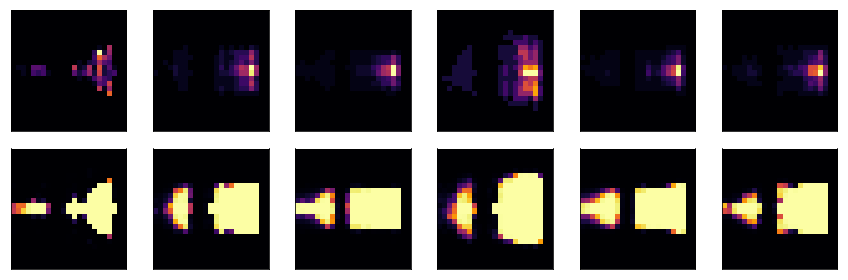

In [36]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 6  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    j = np.random.randint(0, high=len(X_test))
    plt.imshow(X_test[j].reshape(23, 24).T, cmap='inferno')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[j].reshape(23, 24).T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [37]:
# encode every data 
encoded_imgs = encoder.predict(X)

In [38]:
encoded_imgs.shape

(362532, 64)

In [39]:
enc = pd.DataFrame()
enc['OBJID'] = full_data['OBJID']
enc['filter'] = full_data['filter']
enc['CLASS'] = full_data['CLASS']
for i in range(encoding_dim):
    enc['encode_{}'.format(i+1)] = encoded_imgs[:, i]
enc.to_csv('ATLAS_LC/deltamdeltat_{}_encoded.csv'.format(encoded.shape[1]))

In [40]:
decoded_imgs = decoder.predict(encoded_imgs)
dec = pd.DataFrame()
dec['OBJID'] = full_data['OBJID']
dec['filter'] = full_data['filter']
dec['CLASS'] = full_data['CLASS']
for i in range(23*24):
    dec['encode_{}'.format(i+1)] = decoded_imgs[:, i]
dec.to_csv('ATLAS_LC/deltamdeltat_{}_decoded.csv'.format(decoded.shape[1]))

MemoryError: 